2025-03-16 12:21:53.827291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742127713.962038    6886 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742127714.003829    6886 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742127714.275909    6886 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742127714.276001    6886 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742127714.276006    6886 computation_placer.cc:177] computation placer alr

Nombre optimal de clusters détecté : 10


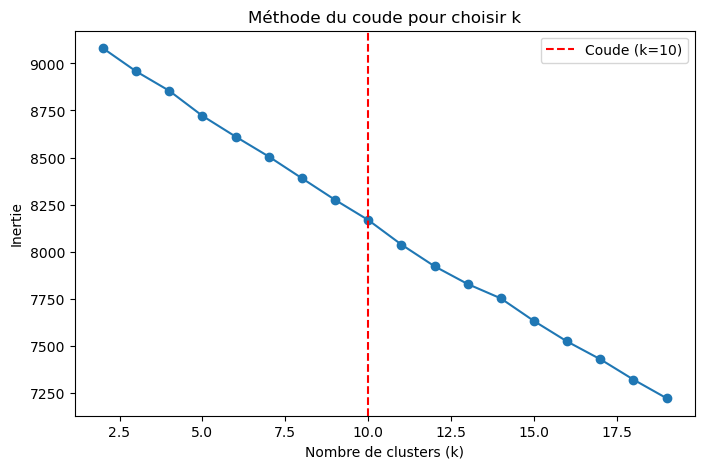

Distance de Levenshtein entre les titres : 64
Similarité cosinus (TF-IDF) entre les contenus : 0.08869096058893602


/home/oumayma/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Similarité cosinus (BERT) entre les contenus : 0.6669040322303772


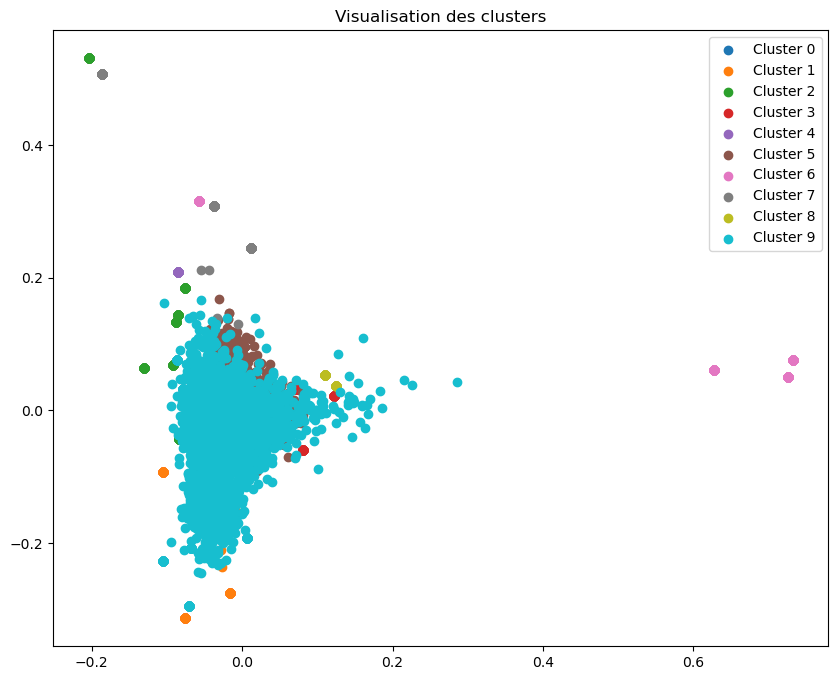

Les résultats ont été enregistrés dans 'clustered_articles.json'.


In [1]:
import json
import Levenshtein
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import numpy as np
from kneed import KneeLocator
import nltk
from nltk.corpus import stopwords

# Télécharger les mots d'arrêt en français
nltk.download('stopwords')
french_stop_words = stopwords.words('french')

# Étape 1 : Charger les données JSON
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# Chemin vers votre fichier JSON
file_path = 'combined_db.json'
data = load_data(file_path)

# Filtrer les articles avec un contenu et une date disponibles
filtered_data = [article for article in data if article['content'] != "Contenu non disponible" and article['date'] != "Date non disponible"]

# Extraire les titres et le contenu des articles filtrés
titles = [article['title'] for article in filtered_data]
contents = [article['content'] for article in filtered_data]

# Étape 2 : Clustering avec K-means et TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=french_stop_words)
X = vectorizer.fit_transform(contents)

# Déterminer le nombre optimal de clusters (méthode du coude)
inertias = []
k_values = range(2, 20)  # Testez des valeurs de k de 2 à 20

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Détection automatique du coude
knee_locator = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
optimal_k = knee_locator.elbow

if optimal_k is None:
    optimal_k = 10  # Valeur par défaut si aucun coude n'est détecté

print(f"Nombre optimal de clusters détecté : {optimal_k}")

# Tracer la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Coude (k={optimal_k})')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour choisir k')
plt.legend()
plt.show()

# Appliquer K-means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

# Ajouter les labels des clusters aux données filtrées
for i, article in enumerate(filtered_data):
    article['cluster'] = int(kmeans.labels_[i])

# Étape 3 : Calcul de la similarité

# 3.1. Distance de Levenshtein pour les titres
title1 = titles[0]
title2 = titles[1]
levenshtein_distance = Levenshtein.distance(title1, title2)
print(f"Distance de Levenshtein entre les titres : {levenshtein_distance}")

# 3.2. Similarité cosinus avec TF-IDF pour le contenu
content1_vector = X[0]
content2_vector = X[1]
tfidf_cosine_sim = cosine_similarity(content1_vector, content2_vector)
print(f"Similarité cosinus (TF-IDF) entre les contenus : {tfidf_cosine_sim[0][0]}")

# 3.3. Similarité cosinus avec BERT pour le contenu
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
content_embeddings = model.encode(contents)

bert_cosine_sim = cosine_similarity([content_embeddings[0]], [content_embeddings[1]])
print(f"Similarité cosinus (BERT) entre les contenus : {bert_cosine_sim[0][0]}")

# Étape 4 : Visualisation des clusters (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    plt.scatter(X_pca[kmeans.labels_ == cluster, 0], X_pca[kmeans.labels_ == cluster, 1], label=f'Cluster {cluster}')
plt.legend()
plt.title('Visualisation des clusters')
plt.show()

# Étape 5 : Stocker les résultats dans un fichier JSON
output_data = []
for article in filtered_data:
    output_data.append({
        'title': article['title'],
        'date': article['date'],
        'category': article['category'],
        'content': article['content'],
        'cluster': article['cluster']
    })

with open('clustered_articles2.json', 'w', encoding='utf-8') as file:
    json.dump(output_data, file, ensure_ascii=False, indent=4)

print("Les résultats ont été enregistrés dans 'clustered_articles.json'.")